In [1]:
# Device

import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available and will be used.")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

GPU is available and will be used.


In [2]:
#Imports

import os
import json
import random
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer, BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling,
    TapasTokenizer, TapasForMaskedLM,
    AdamW, get_scheduler
)
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from model_complete import JSONBERT_COMPLETE
from dataset import JSONDataset, create_data

import sys
sys.path.append('/root/woojun/')

from utils import (
    _serialize_vanilla,
    _serialize,
    tokenize_table,
    _find_positions,
    mask_entry,
    predict_masked_tokens,
    evaluate_masked_prediction,
    train_eval_rf
)

from sklearn.decomposition import PCA

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available and will be used.


In [3]:
# Tokenizer & config

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased')

In [4]:
# Models

# BERT
bert_base = BertForMaskedLM.from_pretrained('bert-base-uncased')
bert_base = bert_base.to(device)

# TaPas
tapas_name = "google/tapas-base-masklm"
tapas_tokenizer = TapasTokenizer.from_pretrained(tapas_name)
tapas = TapasForMaskedLM.from_pretrained(tapas_name)
tapas.to(device)

# Ours
ours_path_movie = './models/movie_complete/epoch-9'
ours_movie = JSONBERT_COMPLETE(config, tokenizer, ours_path_movie)
ours_movie = ours_movie.to(device)

ours_path_movie_prev = './models/movie_complete_prev/epoch-9'
ours_movie_prev = JSONBERT_COMPLETE(config, tokenizer, ours_path_movie)
ours_movie_prev = ours_movie_prev.to(device)

ours_path_product = './models/product_complete/epoch-9'
ours_product = JSONBERT_COMPLETE(config, tokenizer, ours_path_product)
ours_product = ours_product.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Key embeddings are trainable!
Pre-trained JSONBERT loaded from ./models/movie_complete/epoch-9
Key embeddings are trainable!
Pre-trained JSONBERT loaded from ./models/movie_complete/epoch-9
Key embeddings are trainable!
Pre-trained JSONBERT loaded from ./models/product_complete/epoch-9


In [5]:
ours_base = JSONBERT_COMPLETE(config, tokenizer)
ours_base = ours_base.to(device)

Key embeddings are trainable!


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def get_embedding(entry, model, tokenizer):
    inputs, _ = tokenize_table(entry, tokenizer)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True) 

    if hasattr(model, "key_embedding"):
        last_hidden_state = outputs["hidden_states"][-1]
    else:
        last_hidden_state = outputs.hidden_states[-1]

    embedding = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

In [7]:
# English tables
# movie_json1 = create_data('./data/Movie_top100/Movie_apple.com_October2023.json', 'json')
# movie_json2 = create_data('./data/Movie_top100/Movie_davinotti.com_October2023.json', 'json')
# product_json1 = create_data('./data/Product_top100/Product_shoplightspeed.com_October2023.json', 'json')
# product_json2 = create_data('./data/Product_top100/Product_farfetch.com_October2023.json', 'json')

# Random tables
movie_json1 = create_data('./data/Movie_top100/Movie_dvdsreleasedates.com_October2023.json', 'json')
movie_json2 = create_data('./data/Movie_top100/Movie_pix-geeks.com_October2023.json', 'json')
product_json1 = create_data('./data/Product_top100/Product_yahoo.com_October2023.json', 'json')
product_json2 = create_data('./data/Product_top100/Product_all.biz_October2023.json', 'json')


movie_json1 = random.sample(movie_json1, 1000)
movie_json2 = random.sample(movie_json2, 1000)
product_json1 = random.sample(product_json1, 1000)
product_json2 = random.sample(product_json2, 1000)


In [8]:
def visualize_clusters(model, tokenizer):
    movie_table1_embeddings = np.array([get_embedding(row, model, tokenizer) for row in movie_json1])
    movie_table2_embeddings = np.array([get_embedding(row, model, tokenizer) for row in movie_json2])
    product_table1_embeddings = np.array([get_embedding(row, model, tokenizer) for row in product_json1])
    product_table2_embeddings = np.array([get_embedding(row, model, tokenizer) for row in product_json2])

    # Combine embeddings and create labels
    embeddings = np.vstack([movie_table1_embeddings, movie_table2_embeddings, product_table1_embeddings, product_table2_embeddings])
    labels = (['Movie Table 1'] * len(movie_table1_embeddings) +
            ['Movie Table 2'] * len(movie_table2_embeddings) +
            ['Product Table 1'] * len(product_table1_embeddings) +
            ['Product Table 2'] * len(product_table2_embeddings))

    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 6))
    for label in set(labels):
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=label)

    plt.title('Embedding Distribution by Domain and Table')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

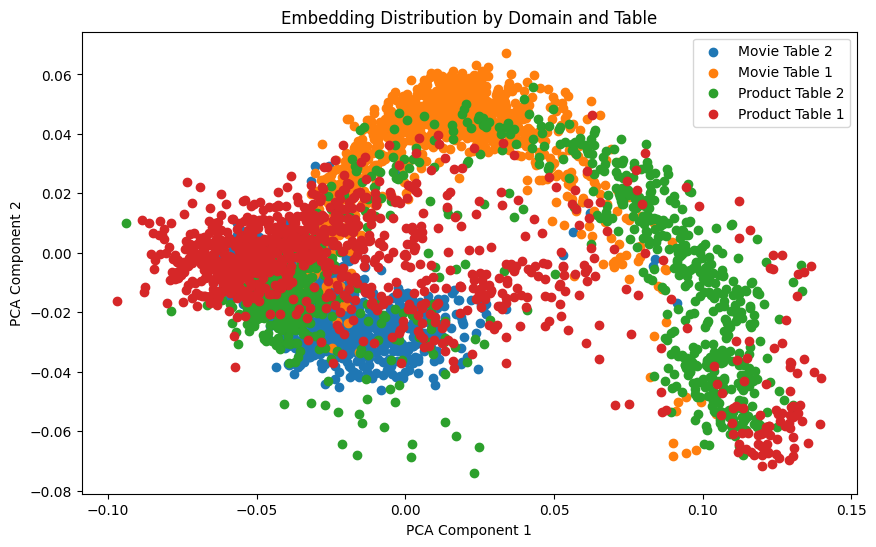

In [9]:
visualize_clusters(ours_movie, tokenizer)

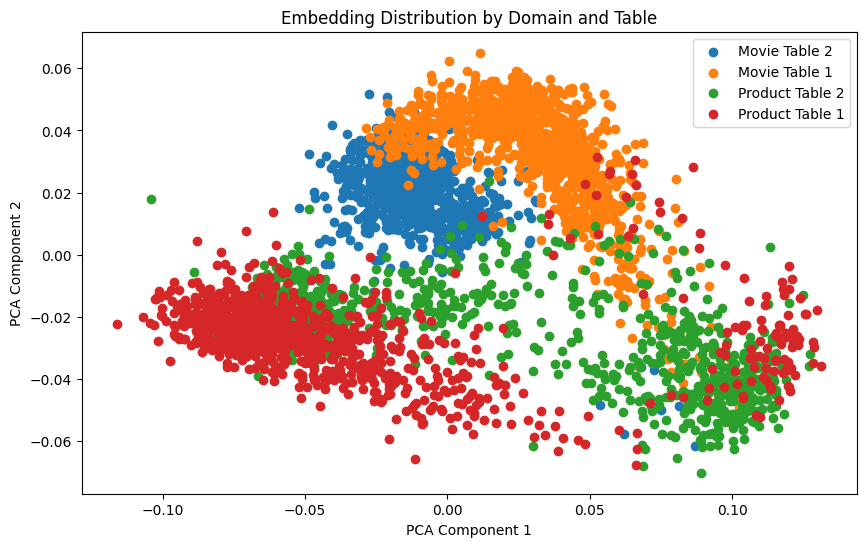

In [10]:
visualize_clusters(ours_product, tokenizer)

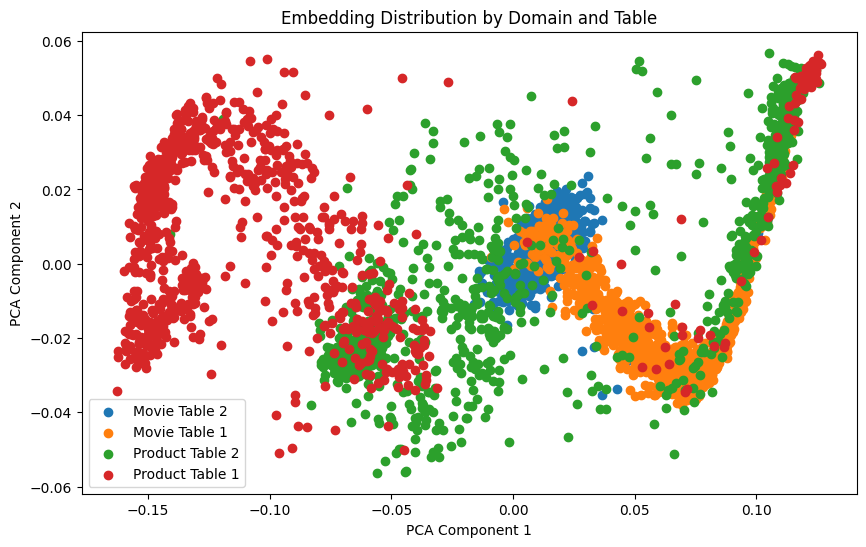

In [11]:
visualize_clusters(ours_base, tokenizer)

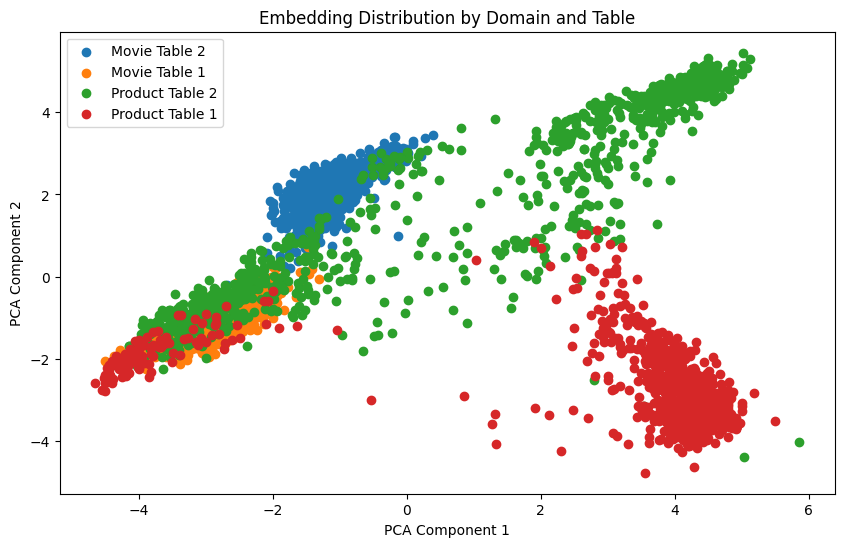

In [12]:
visualize_clusters(bert_base, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:2699: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:1493: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]


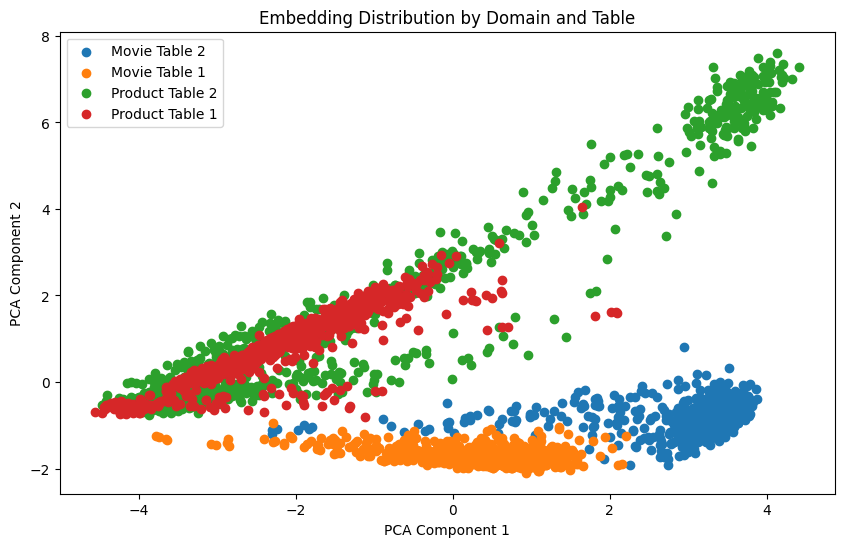

In [13]:
visualize_clusters(tapas, tapas_tokenizer)

In [ ]:
# def run_clustering_experiment(X, y):
#     # Convert labels to binary format
#     unique_labels = np.unique(y)
#     n_clusters = len(unique_labels)

#     # Run K-Means clustering with the number of ground truth clusters
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
#     kmeans.fit(X)

#     # Predict clusters for test data
#     cluster_labels = kmeans.predict(X)

#     # Evaluate clustering performance
#     nmi = normalized_mutual_info_score(y, cluster_labels)
#     print(f"Normalized Mutual Information (NMI) on test data: {nmi:.2f}")

#     ari = adjusted_rand_score(y, cluster_labels)
#     print(f"Adjusted Rand Index (ARI) on test data: {ari:.2f}")

#     # Verify data sizes
#     print(f"X shape: {X.shape}, y length: {len(y)}")

#     # Check unique labels
#     print(f"Unique labels in y: {np.unique(y)}")


#     # Visualize clustering
#     plt.figure(figsize=(8, 6))
#     plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='tab20', marker='o', edgecolor='k')
#     plt.title(f"K-Means Clustering Results with {n_clusters} Clusters")
#     plt.xlabel("Feature 1")
#     plt.ylabel("Feature 2")
#     plt.legend(['Cluster ' + str(i) for i in range(n_clusters)])
#     plt.show()

In [14]:
# BERT
bert_movie = BertForMaskedLM.from_pretrained('./models/movie_bert_prev/epoch-9', local_files_only=True)
bert_movie = bert_movie.to(device)

In [16]:
# BERT
bert_product = BertForMaskedLM.from_pretrained('./models/product_bert_prev/epoch-9', local_files_only=True)
bert_product = bert_product.to(device)

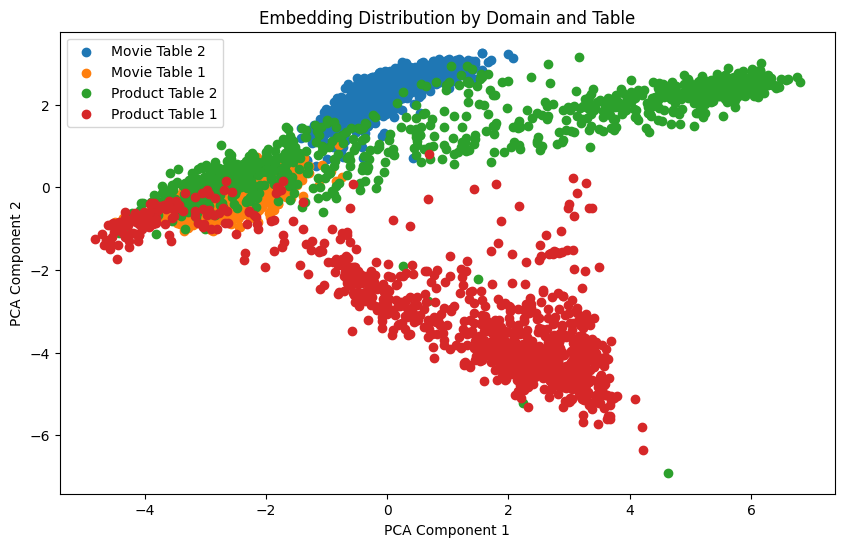

In [17]:
visualize_clusters(bert_product, tokenizer)

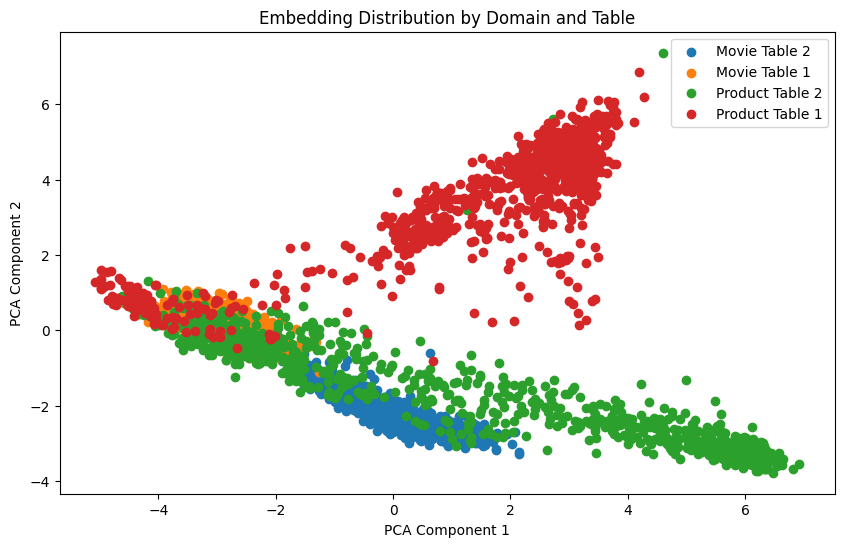

In [15]:
visualize_clusters(bert_movie, tokenizer)